In [1]:
import sys
sys.path.append("../src/")
from data import train_valid_testloader_from_pc, LogTransform, NonTransform, StandardScaler, MinMaxScaler, PowerTransformer
from model import AEDist
import numpy as np
import torch
import phate
from heatgeo.embedding import HeatGeo
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from scipy.spatial import procrustes
import scanpy as sc
import scprep
import matplotlib.pyplot as plt
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import wandb
import hydra
import os
from omegaconf import DictConfig, OmegaConf
import wandb
from hydra import initialize, compose
import pickle
import pandas as pd
from metrics import mAP, computeKNNmAP

In [2]:
data_all = np.load('../data/sea_ad_gaba.npz')#, data=data, phate=Y_phate, dist=X_dist, colors=colors.values)

In [3]:
data = data_all['data']
X_dist = data_all['dist']
Y_phate = data_all['phate']
colors = data_all['colors']

In [4]:
cfg = OmegaConf.load(f'../src/wandb/run-20240116_234835-i4qjbj3e/files/config.yaml')

In [5]:
activation_dict = {
    'relu': torch.nn.ReLU(),
    'leaky_relu': torch.nn.LeakyReLU(),
    'sigmoid': torch.nn.Sigmoid()
}

activation_fn = activation_dict[cfg.model.value['activation']]

In [6]:
preprocessor_dict = {
    'standard': StandardScaler(),
    'minmax': MinMaxScaler(),
    'power': PowerTransformer(),
    'log': LogTransform(),
    'none': NonTransform()
}
pp = preprocessor_dict[cfg.data.value['preprocess']]

In [7]:
ckpt_path=f'../src/wandb/run-20240116_234835-i4qjbj3e/files/epoch=0-step=2422.ckpt'
activation_dict = {
    'relu': torch.nn.ReLU(),
    'leaky_relu': torch.nn.LeakyReLU(),
    'sigmoid': torch.nn.Sigmoid()
}
model = AEDist.load_from_checkpoint(
    checkpoint_path=ckpt_path,
    dim=data.shape[1],
    emb_dim=Y_phate.shape[1],
    layer_widths=cfg.model.value['layer_widths'],
    activation_fn=activation_fn,
    dist_reconstr_weights=cfg['model.dist_reconstr_weights'].value,
    pp=pp,
    lr=cfg.model.value['lr'],
    dist_recon_topk_coords=cfg.model.value['dist_recon_topk_coords'],
)

In [8]:
X_tensor = torch.from_numpy(data).float()
xhat, z = model(X_tensor)
xhat = xhat.cpu().detach().numpy()
z = z.cpu().detach().numpy()

In [9]:
recon_rmse = np.sqrt(np.square(xhat - X_tensor.numpy()).mean())

pc_rot, z_rot, disparity = procrustes(Y_phate, z)
# z_rot = procrustes.transform(z)

# fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# # Plot the first scatter plot
# scprep.plot.scatter2d(Y_phate, ax=axes[0], c=colors, cmap='Spectral',
#                       ticks=False, label_prefix="PHATE ", title='PHATE')

# # Plot the second scatter plot
# scprep.plot.scatter2d(z_rot, ax=axes[1], c=colors, cmap='Spectral',
#                       ticks=False, label_prefix="latent ", title='DMAE latent')
# plt.suptitle(f"EB data, disparity={disparity:.4f}, recon_rmse={recon_rmse:.4f}")
# plt.tight_layout()
# plt.show()

In [10]:
ks = [5, 10, 20, 50, 100]
map_scores_phate = [computeKNNmAP(Y_phate, data, k) for k in ks]
map_scores_dmae = [computeKNNmAP(z_rot, data, k) for k in ks]

In [11]:
map_scores_df = pd.DataFrame({'k': ks, 'PHATE': map_scores_phate, 'DMAE': map_scores_dmae})

In [12]:
map_scores_df

,k,PHATE,DMAE
0,5,0.180503,0.085988
1,10,0.217955,0.118197
2,20,0.269965,0.168247
3,50,0.371950,0.273415
4,100,0.464490,0.384248


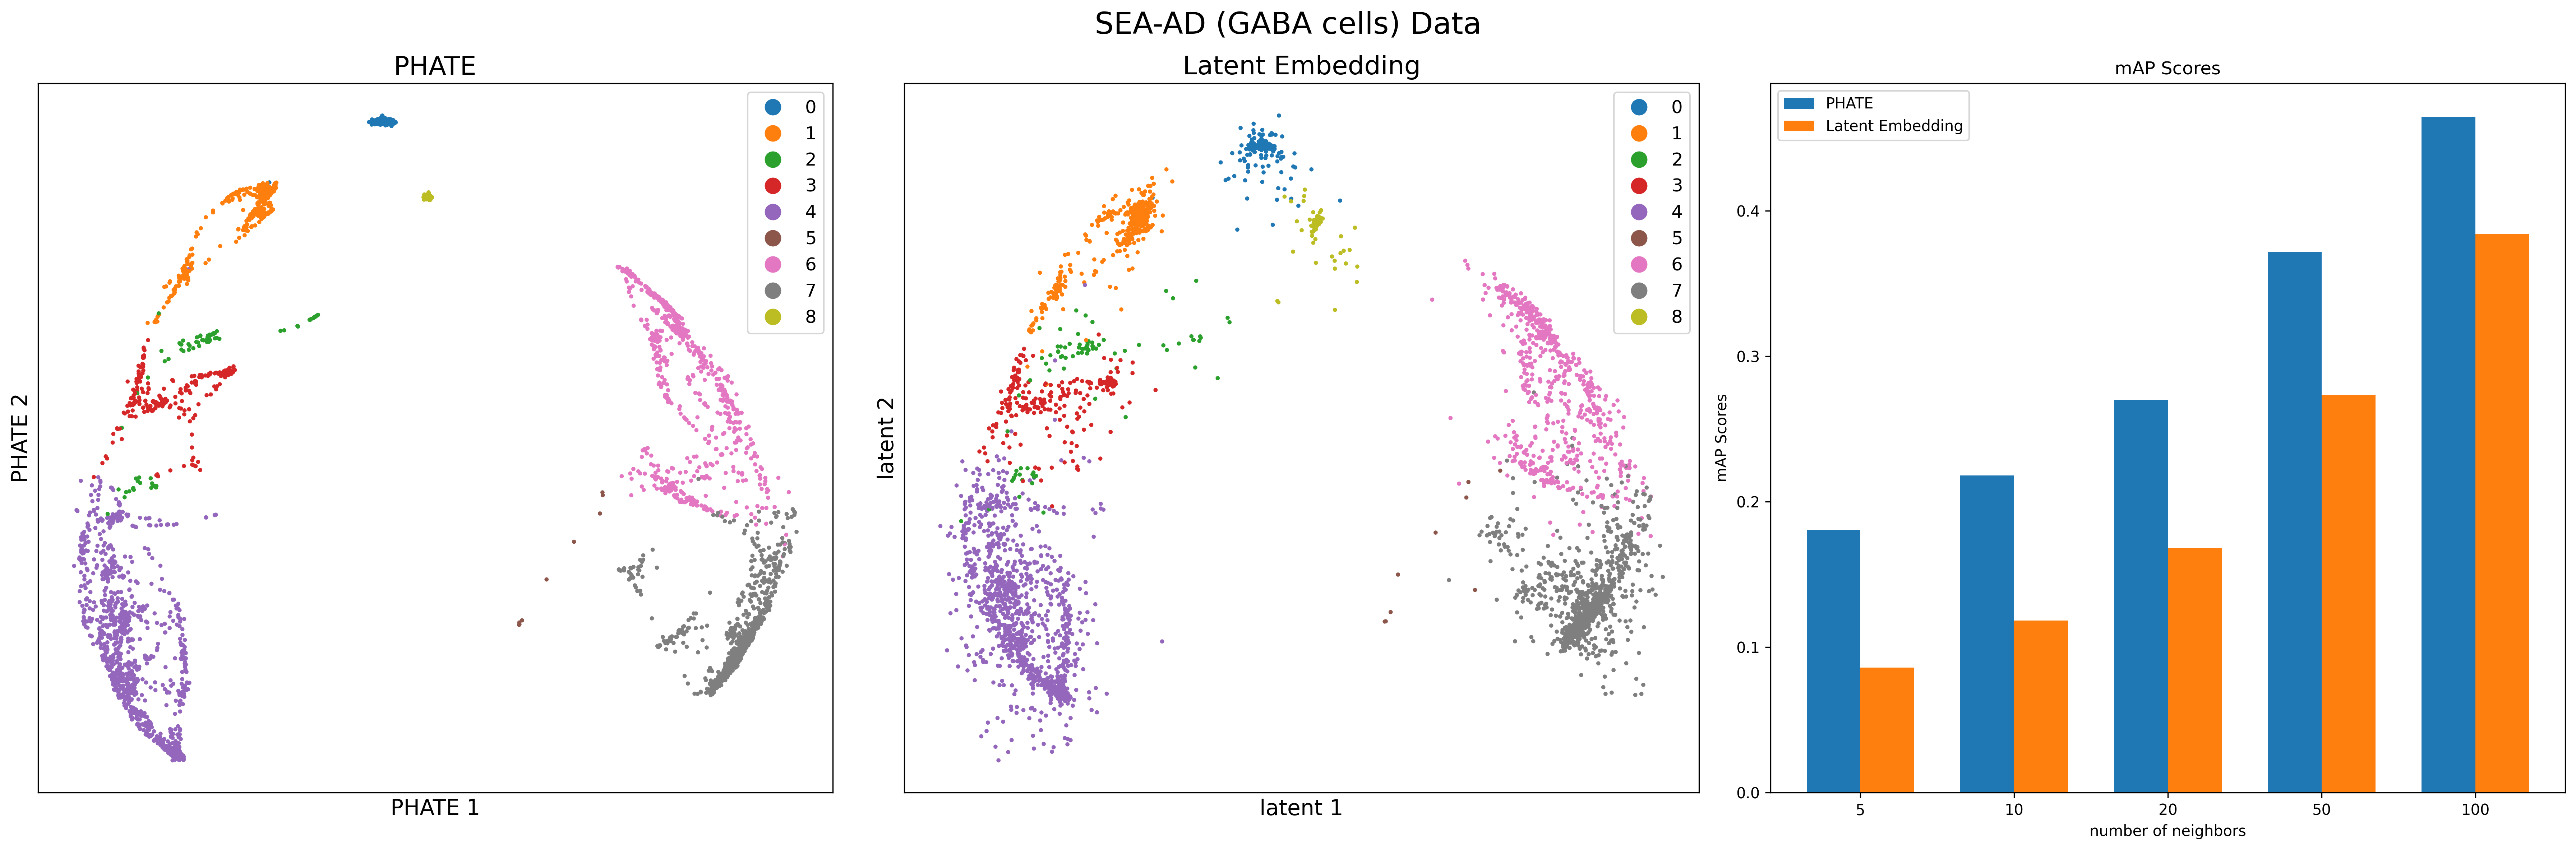

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8), dpi=300)  # Modify the number of subplots to 3, adjust the figsize, and set dpi to 300

# Rest of the code remains the same
scprep.plot.scatter2d(Y_phate, ax=axes[0], c=colors, #cmap='Spectral',
                      ticks=False, label_prefix="PHATE ", title='PHATE')

scprep.plot.scatter2d(z_rot, ax=axes[1], c=colors, #cmap='Spectral',
                      ticks=False, label_prefix="latent ", title='Latent Embedding')

bar_width = 0.35
bar_positions_phate = np.arange(len(ks))
bar_positions_dmae = bar_positions_phate + bar_width

axes[2].bar(bar_positions_phate, map_scores_phate, width=bar_width, label='PHATE')
axes[2].bar(bar_positions_dmae, map_scores_dmae, width=bar_width, label='Latent Embedding')

axes[2].set_xlabel('number of neighbors')
axes[2].set_ylabel('mAP Scores')
axes[2].set_xticks(bar_positions_phate + bar_width / 2)
axes[2].set_xticklabels(ks)

axes[2].legend()
axes[2].set_title('mAP Scores')

plt.suptitle(f"SEA-AD (GABA cells) Data", fontsize=20)

plt.tight_layout()
plt.show()
